# **Libraries and requirements**


In [3]:
pip install sentence-transformers umap-learn scikit-learn matplotlib seaborn pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Arreglar instalación/import de UMAP en Colab
!pip -q uninstall -y umap
!pip -q install -U umap-learn

# Import correcto (NO uses "import umap")
import umap.umap_ as umap



c:\Users\Hiram\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Implementacion UMAP y Hierarchical clustering**

In [5]:
#Nuevo notebook para crear Silhoute Score
import numpy as np
import pandas as pd
import optuna
import umap.umap_ as umap
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from tabulate import tabulate

url_dataset = 'https://raw.githubusercontent.com/HiramZ04/Cal-State-UMAP_Clustering/refs/heads/main/palabras_50_sin_acentos.csv'
df = pd.read_csv(url_dataset)

ST_model = SentenceTransformer('all-MiniLM-L6-v2')
ST_Embeddings = ST_model.encode(df['palabra'])

umap_model = umap.UMAP(n_neighbors = 8, min_dist= 0.1, n_components=2, metric = 'cosine')
low_dimension = umap_model.fit_transform(ST_Embeddings)

clustering_model = AgglomerativeClustering(n_clusters = 7, linkage='complete', metric='cosine')
clusters = clustering_model.fit_predict(low_dimension)

table = np.column_stack((df['palabra'],clusters))
print(tabulate(table[:5] ,headers=('Words','Clusters'), tablefmt ='fancy_grid'))


╒═════════╤════════════╕
│ Words   │   Clusters │
╞═════════╪════════════╡
│ cat     │          0 │
├─────────┼────────────┤
│ dog     │          0 │
├─────────┼────────────┤
│ car     │          1 │
├─────────┼────────────┤
│ bus     │          1 │
├─────────┼────────────┤
│ train   │          1 │
╘═════════╧════════════╛


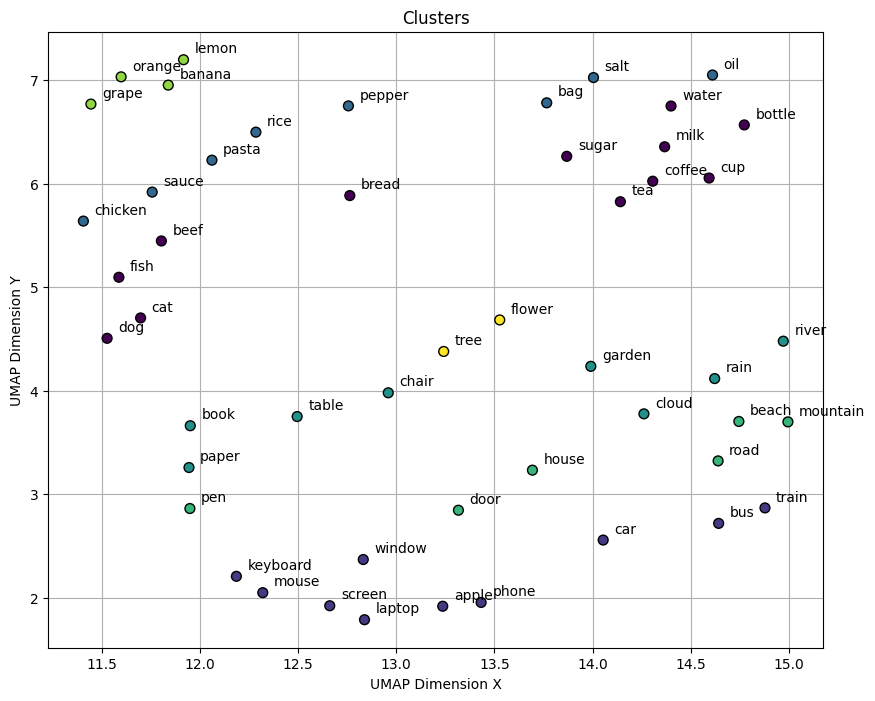

In [6]:
plt.figure(figsize=(10,8))
plt.grid(True)
plt.scatter(low_dimension[:,0],low_dimension[:,1],c=clusters,s=50,edgecolor='k',zorder=2)
plt.xlabel("UMAP Dimension X")
plt.ylabel("UMAP Dimension Y")
plt.title("Clusters")
for xi, yi, w in zip(low_dimension[:,0],low_dimension[:,1],df['palabra']):
  plt.annotate(w, (xi,yi),xytext=(8, 5), textcoords="offset points")
plt.show()

# **Silhoutte Score - para ver el desempeño**

In [7]:
#Trying to implement silhoutte scoroe:

s = silhouette_score(low_dimension, clusters, metric='cosine')
print(f'Current Silhouette Coefficient s = {s:.2f}')

scores = []
list_i = []
print("\n\nNext, we are going to print a for loop with the best clusters options from 2 to 21: \n\n")
#We try to get it into a for for different clusters qty
for i in range (2,21):
  clustering_model_i = AgglomerativeClustering(n_clusters = i, linkage='average', metric='cosine')
  clusters_i = clustering_model_i.fit_predict(low_dimension)
  s_i = np.round(silhouette_score(low_dimension, clusters_i, metric='cosine'),4)
  scores.append(s_i)
  list_i.append(i)
  print(f'Silhouette Coefficient {i} = ', s_i)

#We pass the list append to an np.array to use max() function
array = np.array(scores)
print("\nThe highest score of Silhoutte Coeficcient was: ",array.max())
print("With these qty of Clusters: ",array.argmax()+2) #le sumamos 2 porque la lista en realidad se itero desde el 2 al 21 no del 0 al 20


Current Silhouette Coefficient s = 0.74


Next, we are going to print a for loop with the best clusters options from 2 to 21: 


Silhouette Coefficient 2 =  0.8505
Silhouette Coefficient 3 =  0.7812
Silhouette Coefficient 4 =  0.7225
Silhouette Coefficient 5 =  0.7056
Silhouette Coefficient 6 =  0.752
Silhouette Coefficient 7 =  0.7376
Silhouette Coefficient 8 =  0.7832
Silhouette Coefficient 9 =  0.7906
Silhouette Coefficient 10 =  0.8164
Silhouette Coefficient 11 =  0.7862
Silhouette Coefficient 12 =  0.79
Silhouette Coefficient 13 =  0.7809
Silhouette Coefficient 14 =  0.7636
Silhouette Coefficient 15 =  0.7751
Silhouette Coefficient 16 =  0.773
Silhouette Coefficient 17 =  0.7406
Silhouette Coefficient 18 =  0.7164
Silhouette Coefficient 19 =  0.6959
Silhouette Coefficient 20 =  0.6946

The highest score of Silhoutte Coeficcient was:  0.8505
With these qty of Clusters:  2


Text(0.5, 1.0, 'Silhoutte Score on Number of Clusters')

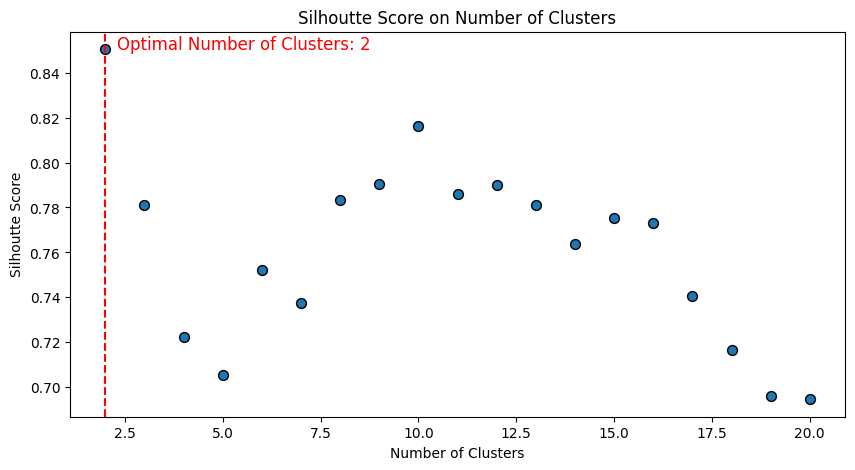

In [8]:
#Antes de optimizar con OPTUNA graficamos la mejor opcion de clusters en base a Silhoutte Score

plt.figure(figsize=(10,5))
plt.scatter(list_i, array, s=50, edgecolor='k')
plt.axvline(x=array.argmax()+2, linestyle='--', color='red')
plt.annotate(f'Optimal Number of Clusters: {array.argmax()+2}', xy=(array.argmax()+2, array.max()), xytext=(array.argmax()+2.3, array.max()),
            color='red', fontsize=12)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhoutte Score")
plt.title("Silhoutte Score on Number of Clusters")



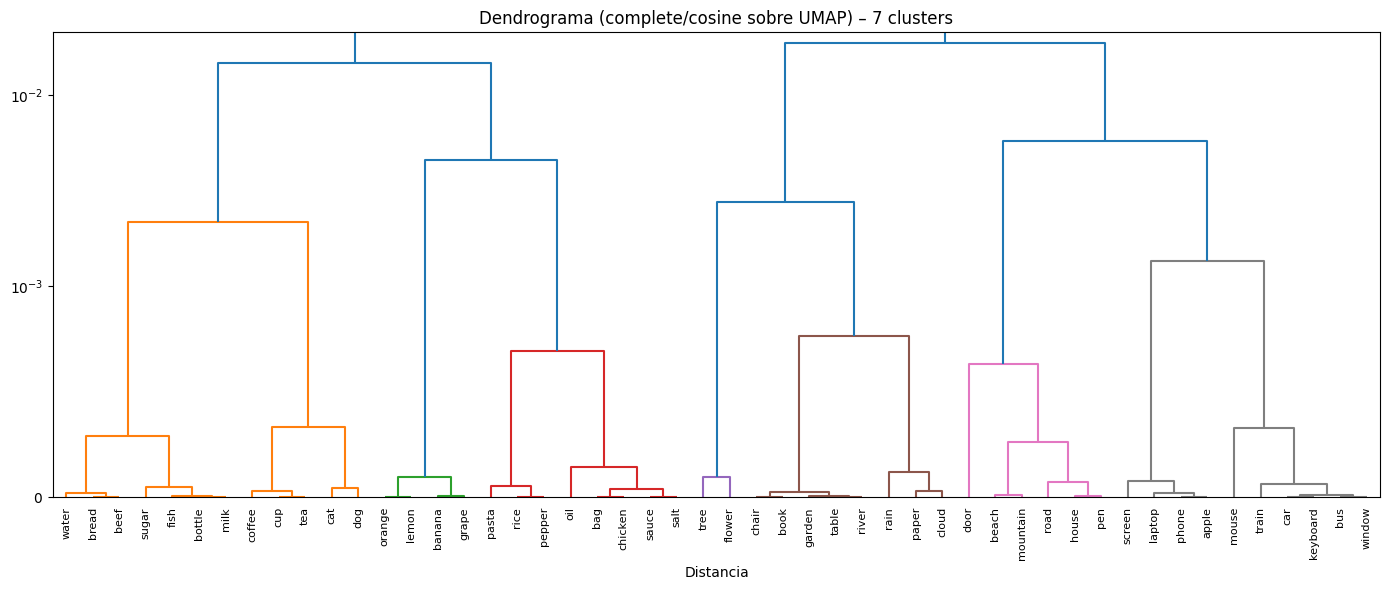

In [9]:
# Dendrograma sobre UMAP, con estirado de distancias pequeñas y recorte del eje
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import numpy as np
import matplotlib.pyplot as plt

k = 7
GAMMA = 1       # 1.0 = sin cambio; 0.5 = sqrt(x); 0.33 = raíz cúbica (más estirado)
Q = 0.98           # recorta al percentil 98% para quitar colas largas
USE_SYMLOG = True  # escala log cercana a 0 para separar raíces

model = AgglomerativeClustering(
    distance_threshold=0, n_clusters=None,
    linkage='complete', metric='cosine',
    compute_distances=True
).fit(low_dimension)

# --- linkage_matrix a partir del modelo ---
counts = np.zeros(model.children_.shape[0])
n = len(model.labels_)
for i, merge in enumerate(model.children_):
    cnt = 0
    for m in merge:
        cnt += 1 if m < n else counts[m - n]
    counts[i] = cnt

# Estira distancias pequeñas de forma monótona (mantiene el orden de fusiones)
dist = np.power(model.distances_.copy(), GAMMA)
Z = np.column_stack([model.children_, dist, counts]).astype(float)

# Umbral para colorear exactamente k clusters (con distancias estiradas)
t = n - k
color_th = dist[t]

plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    labels=df['palabra'].astype(str).tolist(),
    orientation='top',
    leaf_font_size=8,
    color_threshold=color_th,
    distance_sort='ascending'
)

ax = plt.gca()
if USE_SYMLOG:
    ax.set_yscale('symlog', linthresh=1e-3)  # separa raíces pegadas a 0
plt.ylim(0, np.quantile(Z[:,2], Q))          # recorta arriba para que se aprecie mejor
plt.title(f'Dendrograma (complete/cosine sobre UMAP) – {k} clusters')
plt.xlabel('Distancia')
plt.tight_layout()
plt.show()


# **Optuna - mejora de hiperparametros**

In [10]:
# Implementando Optuna:
import optuna

# Defino funcion trial donde busco los mejores hiperparametros simultaneamente de UMAP y AgglomerativeClustering ya que los 2 son simultaneos

def objective(trial):
    # Definimos HiperParametros
    min_dist = trial.suggest_float('min_dist', 0.01, 0.2)    # UMAP
    n_neighbors = trial.suggest_int('n_neighbors', 2, 20) # UMAP
    n_clusters = trial.suggest_int('n_clusters', 2, 20)  # Agglomerative Clustering
    agg_linkage = trial.suggest_categorical('agg_linkage', ['average', 'complete']) # Agglomerative Clustering

    # UMAP
    umap_model = umap.UMAP(n_neighbors = n_neighbors, min_dist = min_dist, n_components = 2, metric = 'cosine', random_state=42)
    low_dimension_words = umap_model.fit_transform(ST_Embeddings)

    # Clustering
    clustering_model = AgglomerativeClustering(n_clusters = n_clusters, linkage = agg_linkage, metric = 'cosine')
    clusters = clustering_model.fit_predict(low_dimension_words)

    # Silhoutte Score
    s_score = silhouette_score(low_dimension_words, clusters, metric='cosine')

    return s_score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

study.best_params

[I 2025-10-02 12:07:49,043] A new study created in memory with name: no-name-b807d158-3731-4780-ab80-85e435cab547
c:\Users\Hiram\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
[I 2025-10-02 12:07:49,376] Trial 0 finished with value: 0.7345291376113892 and parameters: {'min_dist': 0.05716249380585259, 'n_neighbors': 20, 'n_clusters': 6, 'agg_linkage': 'average'}. Best is trial 0 with value: 0.7345291376113892.
c:\Users\Hiram\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
[I 2025-10-02 12:07:49,395] Trial 1 finished with value: 0.8232988715171814 and parameters: {'min_dist': 0.10725716105903671, 'n_neighbors': 3, 'n_clusters': 15, 'agg_linkage': 'average'}. Best is trial 1 with value: 0.8232988715171814.
c:\Users\Hiram

{'min_dist': 0.15632306952209507,
 'n_neighbors': 2,
 'n_clusters': 10,
 'agg_linkage': 'average'}

In [11]:
# Silhoutte score de los hiperparametros optimizados
import numpy as np
import pandas as pd
import optuna
import umap.umap_ as umap
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from tabulate import tabulate

url_dataset = 'https://raw.githubusercontent.com/HiramZ04/Cal-State-UMAP_Clustering/refs/heads/main/palabras_50_sin_acentos.csv'
df_opt = pd.read_csv(url_dataset)

ST_model_opt = SentenceTransformer('all-MiniLM-L6-v2')
ST_Embeddings_opt = ST_model_opt.encode(df_opt['palabra'])

umap_optimized = umap.UMAP(n_neighbors = 2, min_dist= 0.05664884754928642, n_components=2, metric = 'cosine')
low_dimension_opt = umap_optimized.fit_transform(ST_Embeddings_opt)

clustering_model_opt = AgglomerativeClustering(n_clusters = 12, linkage='average', metric='cosine')
clusters_opt = clustering_model_opt.fit_predict(low_dimension_opt)

table_opt = np.column_stack((df_opt['palabra'],clusters_opt))
print(tabulate(table_opt[:5] ,headers=('Words','Clusters'), tablefmt ='fancy_grid'))

s_opt = silhouette_score(low_dimension_opt, clusters_opt, metric='cosine')
print(f'Current Silhouette Coefficient s = {s_opt:.2f}')


╒═════════╤════════════╕
│ Words   │   Clusters │
╞═════════╪════════════╡
│ cat     │          0 │
├─────────┼────────────┤
│ dog     │          0 │
├─────────┼────────────┤
│ car     │          4 │
├─────────┼────────────┤
│ bus     │          8 │
├─────────┼────────────┤
│ train   │          8 │
╘═════════╧════════════╛
Current Silhouette Coefficient s = 0.95


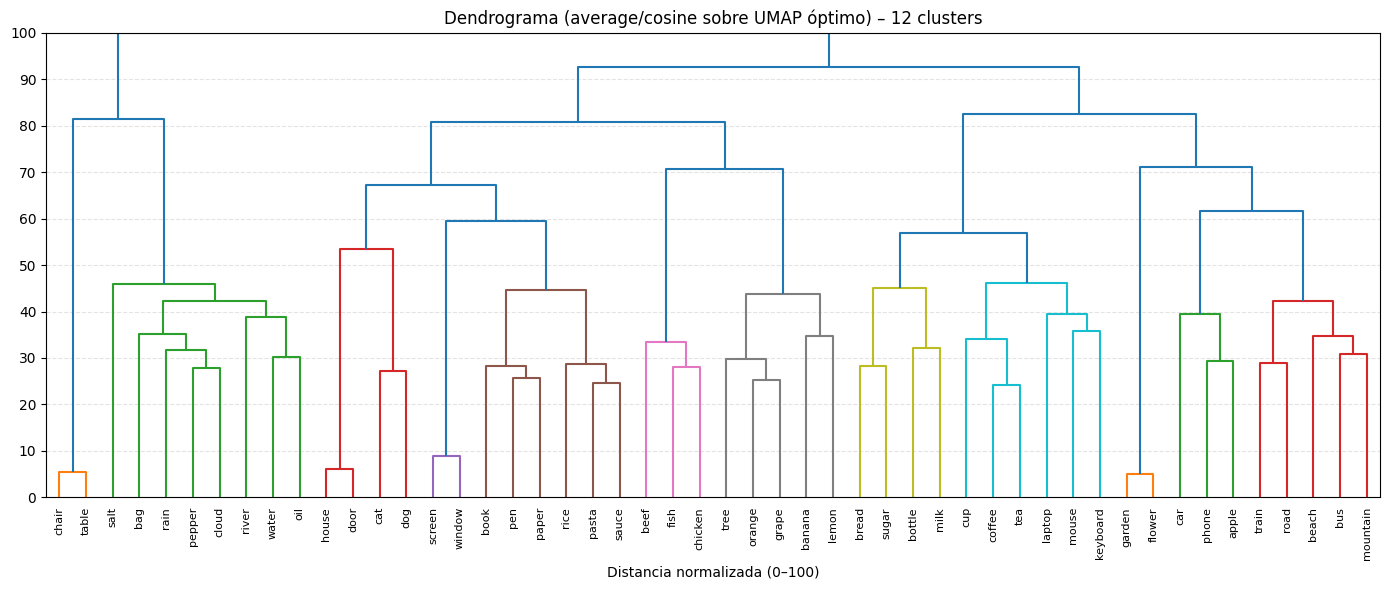

In [12]:
# Dendrograma 
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import numpy as np
import matplotlib.pyplot as plt

k = 12  # tus clusters óptimos

model = AgglomerativeClustering(
    distance_threshold=0, n_clusters=None,
    linkage='average', metric='cosine',
    compute_distances=True
).fit(low_dimension_opt)  # usa el UMAP optimizado

# linkage_matrix (Z) con distancias "bonitas"
n = len(model.labels_)
counts = np.zeros(model.children_.shape[0])
for i, merge in enumerate(model.children_):
    cnt = 0
    for m in merge:
        cnt += 1 if m < n else counts[m - n]
    counts[i] = cnt

dist = model.distances_.copy()
dist = np.power(dist, 0.1)          # estira lo pequeño (prueba 0.4 o 0.33 si quieres más)
dist = (dist / dist.max()) * 100.0  # escala 0–100

Z = np.column_stack([model.children_, dist, counts]).astype(float)

# umbral para colorear exactamente k clusters (en la escala "bonita")
t = n - k
color_th = dist[t]

plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    labels=df_opt['palabra'].astype(str).tolist(),
    orientation='top',
    leaf_font_size=8,
    color_threshold=color_th,
    distance_sort='ascending'
)
plt.ylim(0, 100)
plt.yticks(np.arange(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.title(f'Dendrograma (average/cosine sobre UMAP óptimo) – {k} clusters')
plt.xlabel('Distancia normalizada (0–100)')
plt.tight_layout()
plt.show()


# **Ollama**

## Empezamos a explorar un poco con ollama para usar un LLM local y pedirle las palabras de las intersecciones


In [13]:
from ollama import chat

messages = [
    {
    'role':'user',
    'content':'This is a test prompt just to see if you work!',
    },
]

resp = chat(model = "gemma3:1b", messages=messages)
print(resp['message']['content'])

Okay, fantastic! I appreciate the challenge. Let's do it. 

**Please, tell me what you'd like me to do.** 

I'm ready for anything – a creative writing prompt, a factual question, a riddle, a coding challenge, a story starter, or anything else you have in mind.  Don't hesitate to give me a starting point, or just a general idea. 😊


In [143]:
#Now we see the local llm works 
#We then pass the list of words for the different clusters so he makes the intersection words

words = []
for i, z in (table_opt):
    if z == 4:
        words.append(i)
    
print("We are out of the loop")
print(words)

messages = [
     {
    'role':'system','content':'You are an agent that gives a word for a list of strings, you only output 1 word that can be used to connect the list of strings given'
    },
    {
    'role':'user', 'content':f'This is my list of words, give me only 1 word which can connect all of these words {words}',
    },   
]

resp1b = chat(model = "gemma3:1b", messages=messages)
resp4b = chat(model = "gemma3:latest", messages=messages)
print("gemma 1b response: ",resp1b['message']['content'])
print("gemma 4.3b response: ",resp4b['message']['content'])

We are out of the loop
['car', 'phone', 'apple']
gemma 1b response:  Connection
gemma 4.3b response:  Technology



## Creamos un modelo customizado llamado cal-state_words en base a llm gemma de 4.3 b 

In [140]:
# Vamos a crear nuestro propio modelo en base a gemma3:latest de 4.3 B para asegurarnos de que nuestro modelo solo nos de 
# lo que buscamos, palabras sin conectores como and where y lo mas logico posible. creativity baja

from ollama import Client

client = Client()
response = client.create(
    model = "cal-state_words",
    from_ = "gemma3:latest",
    system = """
    You are strictly a 1 output model, you are used to output 1 single coherent word that is relationated 
    to 2 words, you CAN NOT use connectors like and, but, however, transition. Remember you are searching for a word that is related
    to the input 2 words and give it as an output. you are NOT searching for grammatical connectors. 
    """,
    stream = False,
)

print(response.status)



success


## Empezamos a crear las palabras por cada pareja e interseccion del dendograma al LLM gemma

In [135]:
# Construimos lista de todos los labels para todas las intersecciones

from sklearn.cluster import AgglomerativeClustering
import numpy as np
from ollama import chat

#Volvemos a crear el clustering pero ahora haciendo compute de las distancias para guardarlas en .distances_
model = AgglomerativeClustering(
    distance_threshold=0, n_clusters=None,
    linkage='average', metric='cosine',
    compute_distances=True
).fit(low_dimension_opt)

n = len(model.labels_)  #
dist = model.distances_.copy()
dist = (np.power(dist, 0.1) / dist.max()) * 100.0  # normaliza 0-100

#print(n, dist.shape)  # Espera: n = len(palabras), dist tiene n-1 elementos
#print(dist) #vector de distancias en orden normalizado de 0 al 100
#print(model.children_) # Este es un arreglo que contiene que se unio con quien, que indice se uno con cual

leaf_labels = df_opt['palabra'].tolist() #Este es un arreglo de las palabras con indices para poderlo asociar con el .children
#print(leaf_labels[42] +" - "+ leaf_labels[44]) #Estas son las 2 palabras que se unieron primero segun el model.children

#Z es la matriz que tendria el indice de lo que se unio usando children, despues la distancia con .distances y al final la cantidad de hojas 
#para poder ver el ancho y todo super bien

#Lo que nos falta para construir Z es counts entonces lo construimos
counts = np.zeros(model.children_.shape[0])
for i, merge in enumerate(model.children_):
    cnt = 0
    for m in merge:
        cnt += 1 if m < n else counts[m - n]
    counts[i] = cnt

#Construimos la matriz Z con los indices de lo que se unio, la distancia y el nivel de hoja en el arbol
Z = np.column_stack([model.children_, dist, counts]).astype(float)
#print(Z.shape[0])  
temp = int(0)
words = ["test", "test2"]


'''
for i in range(Z.shape[0]):
   #if Z[i,0] == 42:
        print(Z[i,0], " - ",  Z[i,1])
        temp = int(Z[i,0])
        print("posicion 0:" , temp)
        words[0] = leaf_labels[temp] 
        temp = int(Z[i,1])
        print("posicion 1:" ,temp)
        words[1] = leaf_labels[temp]   # esto esta pasando porque tengo una posicion 57 pero mi lista de palabras es hasta 50 
        print(words)
        print("\n")
'''

#Para poder solucionar el problema que nos encontramos de que el indice es mayor tenemos que compararlo con N que es el lenght
#de nuestras palabras para ver si es hoja o es algo descompuesto de 2 entonces tendriamos que usar children mejor.

children = model.children_.astype(int)
n = len(leaf_labels)



node_label = [None] * (n + (n - 1)) # creamos la lista donde guardaremos TODAS las palabras para no tener problemas de index < 50

# vamos a inicializar con la lista de palabras que yo tengo y se le iran agregando las fusiones
for j in range(n):
    node_label[j] = leaf_labels[j]


for i in range(Z.shape[0]):
   left = int(Z[i, 0])    # el nodo izq es en posicion 0 de la matriz Z
   right = int(Z[i, 1])   # el nodo der es en posicion 1 de la matriz Z
   new = n + i            # cada nodo interno o palabra nueva creada por interseccion esta en el indice n (50) + i que es la posicion en la que vamos

# Si ya existen las palabras las va a buscar en mi lista de palabras indexada 
   left_word = node_label[left]  
   right_word = node_label[right]

# Le pedimos al LLM local que cree la palabra en base a 2 palabras de esta manera siempre tendremos una palabra para poder usar
# en vez de tener un par como garden + flower tenemos together o en vez de tener internal node 69 ya tienes la palabra generada por el LLM
   messages = [
        {"role":"system","content":"You are an agent that gives a word for a list of strings, you only output 1 word that can be used to connect the list of strings given"},
        {"role":"user","content":f"This is my list of words, give me only 1 word which can connect all of these words: {left_word} and {right_word}"}   
    ]
   resp  = chat(model="gemma3:latest", messages=messages)
   label = resp["message"]["content"].strip().split()[0]  # hacemos split del output aunque seguramente solo nos da 1 palabra por el system
   
   # La palabra nueva que genero el LLM para la fusions va en la lista node label en la posicion n (50) mas el i 
   node_label[new] = label 
   print(f"fusion {i}: ({left_word} + {right_word}) -> {label}")
   print(node_label)

print("\nEsta es la lista final de palabras que le podemos pasar al dendograma para que las etiquete: \n", node_label)




fusion 0: (garden + flower) -> Together
['cat', 'dog', 'car', 'bus', 'train', 'road', 'house', 'chair', 'table', 'phone', 'laptop', 'mouse', 'keyboard', 'screen', 'book', 'pen', 'paper', 'bag', 'bottle', 'cup', 'water', 'coffee', 'tea', 'milk', 'bread', 'rice', 'apple', 'banana', 'orange', 'grape', 'lemon', 'fish', 'chicken', 'beef', 'pasta', 'sauce', 'salt', 'sugar', 'pepper', 'oil', 'window', 'door', 'garden', 'tree', 'flower', 'river', 'beach', 'mountain', 'cloud', 'rain', 'Together', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
fusion 1: (chair + table) -> Furniture
['cat', 'dog', 'car', 'bus', 'train', 'road', 'house', 'chair', 'table', 'phone', 'laptop', 'mouse', 'keyboard', 'screen', 'book', 'pen', 'paper', 'bag', 'bottle', 'cup', 'water', 

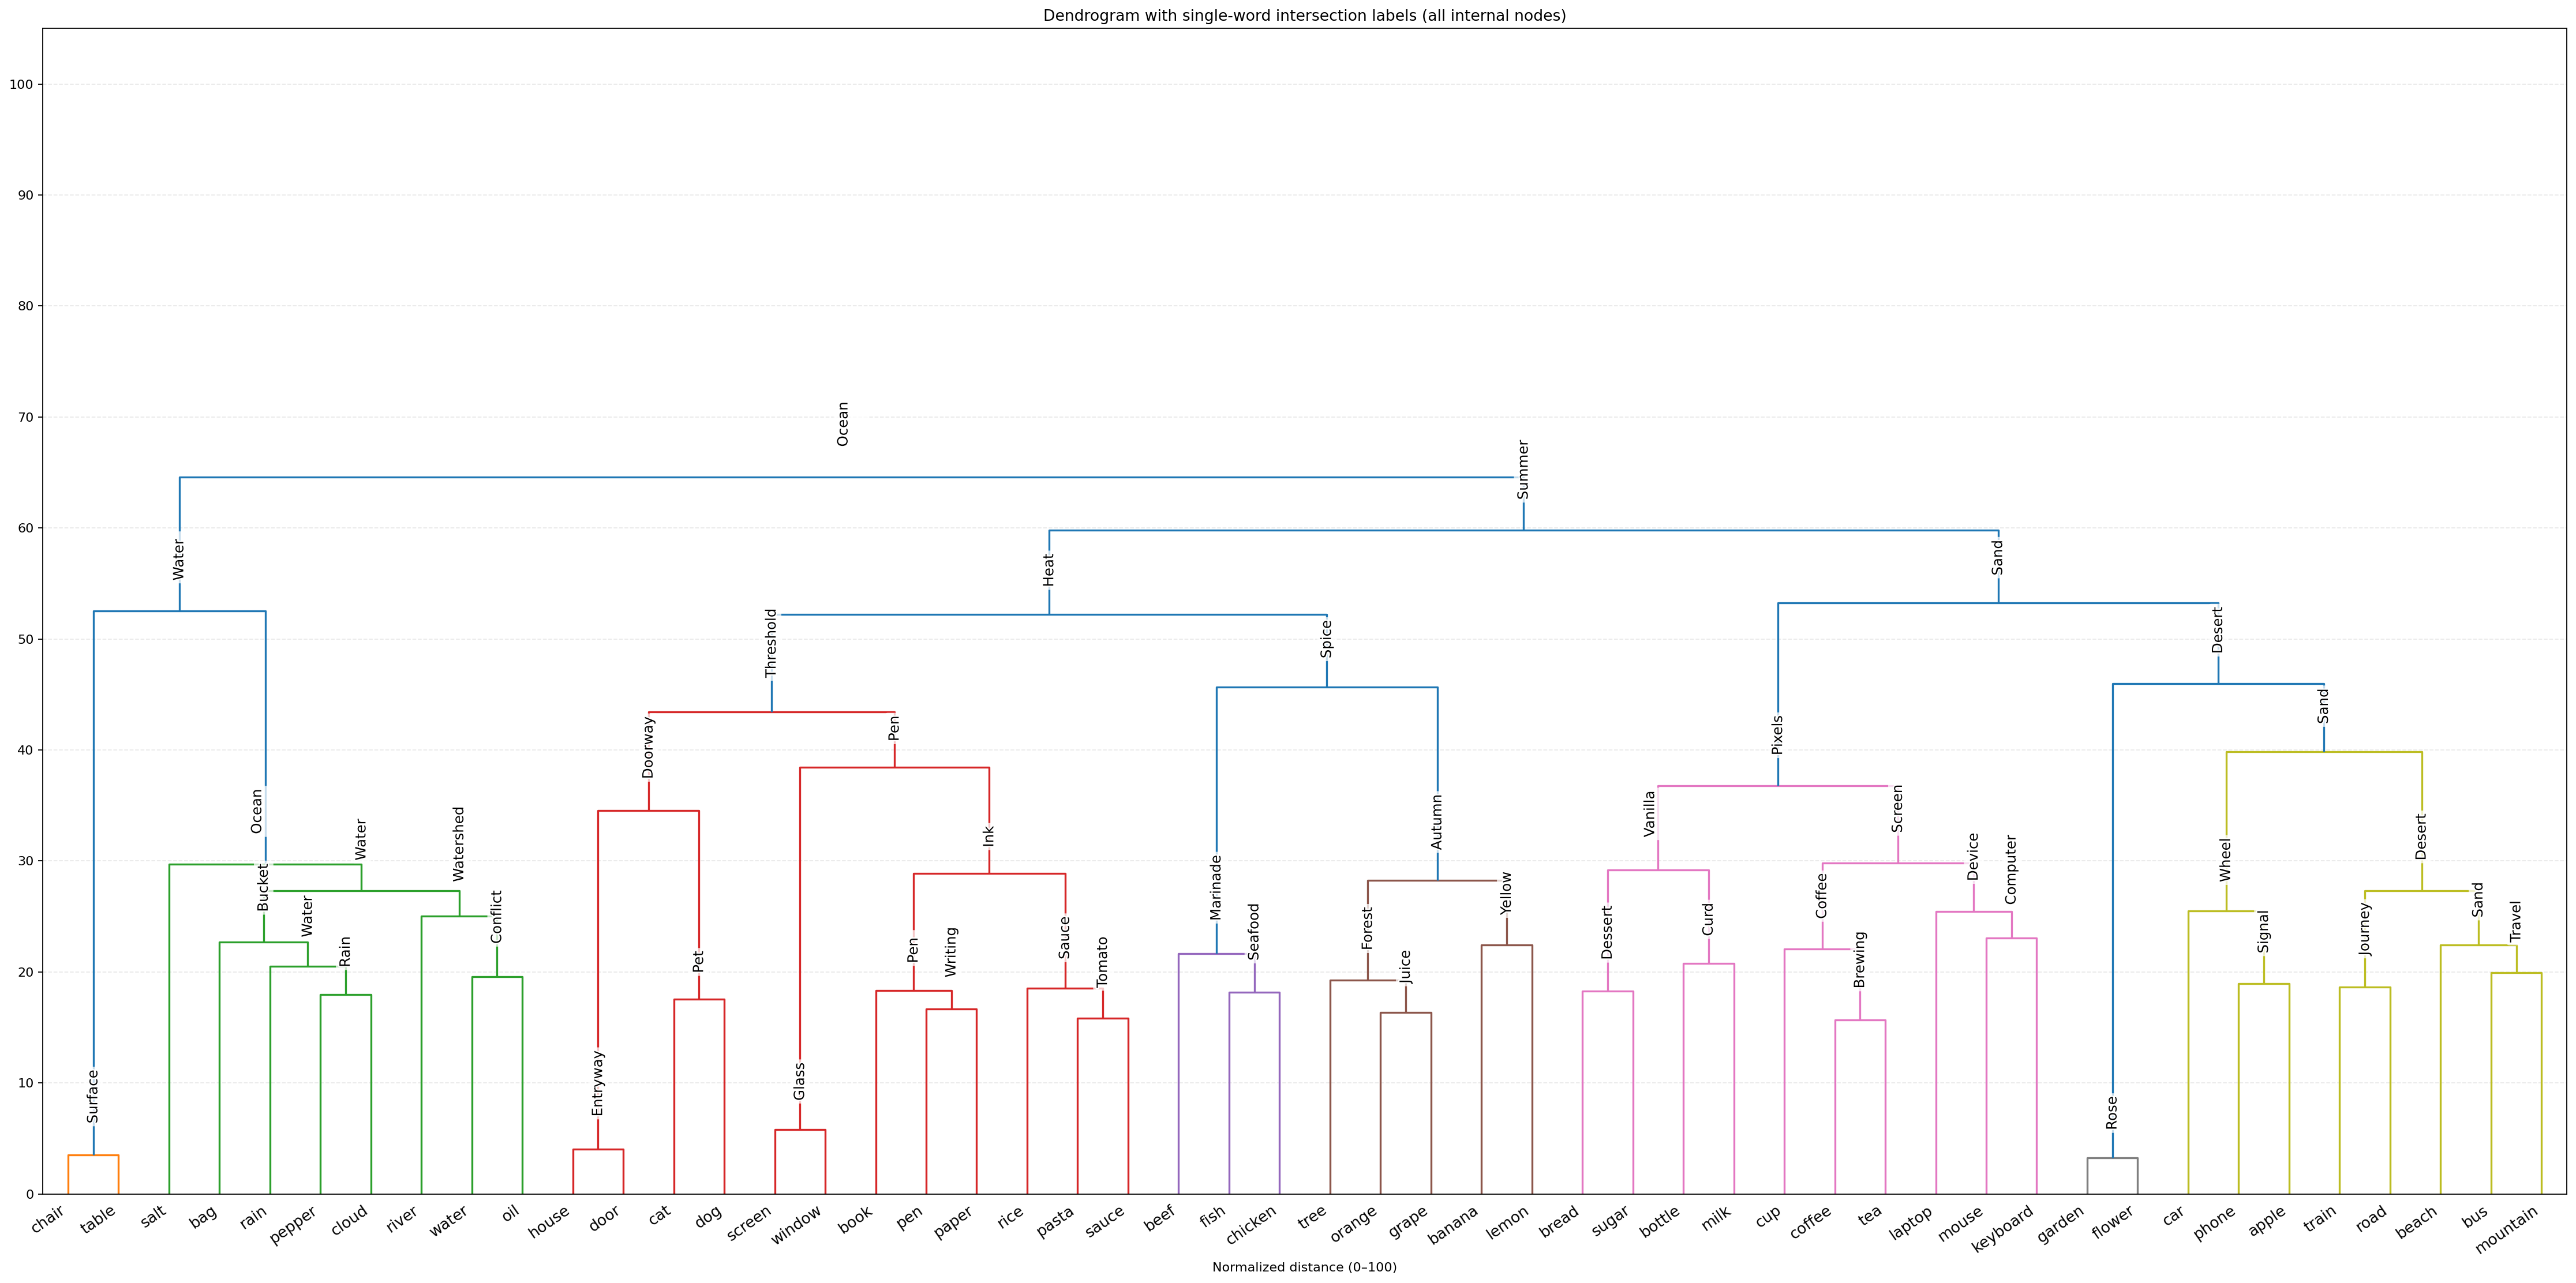

In [ ]:
# Generamos el dendograma, se modifico porque no se miraba bien en el output se perdian las palabras
FIGSIZE = (28, 14)
DPI = 160
LEAF_FONT = 12
LEAF_ROT = 35                # inclina hojas
INTERNAL_FONT = 11
BOX_ALPHA = 0.75
Y_OFFSET = 2.0               # offset base para no tocar la línea
EXTRA_OFFSET_PER_CHAR = 0.12 # sube un poco más según largo del texto
MAX_LABEL_LEN = 18           # recorta internos si son larguitos
ANNOTATE_MIN_Y = 0.0         # si quieres ocultar etiquetas muy bajas, súbelo (p.ej. 8.0)

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import matplotlib.patheffects as pe

def _shorten(s, n=MAX_LABEL_LEN):
  s = str(s)
  return s if len(s) <= n else (s[:n-1] + "…")

# === 1) Dibuja el dendrograma base con las etiquetas de HOJAS ===
plt.rcParams['figure.dpi'] = DPI
leaf_labels = df_opt['palabra'].astype(str).tolist()

fig, ax = plt.subplots(figsize=FIGSIZE)

ddata = dendrogram(
    Z,
    labels=leaf_labels,
    orientation='top',
    leaf_font_size=LEAF_FONT,
    distance_sort='ascending',
)

# Inclina hojas (mejor lectura cuando hay muchas)
ax.set_xticklabels(ax.get_xticklabels(), rotation=LEAF_ROT, ha='right')

ax.set_ylim(0, 105)
ax.set_yticks(np.arange(0, 101, 10))
ax.grid(axis='y', linestyle='--', alpha=0.28)
ax.set_title("Dendrogram with single-word intersection labels (all internal nodes)")
ax.set_xlabel("Normalized distance (0–100)")

# === 2) X reales de hojas según el orden del plot ===
n = len(leaf_labels)
leaf_order = ddata['leaves']
xpos_leaf = {leaf_idx: 5 + 10*i for i, leaf_idx in enumerate(leaf_order)}

# === 3) X para cualquier nodo (promedio de hijos)
children = model.children_.astype(int)
_node_x_cache = {}
def node_x(gidx: int) -> float:
    if gidx in _node_x_cache:
        return _node_x_cache[gidx]
    if gidx < n:
        x = xpos_leaf[gidx]
    else:
        a, b = children[gidx - n]
        x = 0.5 * (node_x(int(a)) + node_x(int(b)))
    _node_x_cache[gidx] = x
    return x

# === 4) Etiquetas de nodos internos, bonitas y legibles ===
for i in range(len(children)):
    gidx = n + i
    y = float(dist[i])
    if y < ANNOTATE_MIN_Y:
        continue

    label = _shorten(node_label[gidx])
    if not label:
        continue

    x = node_x(gidx)
    # desfase vertical extra según largo (evita tapar líneas)
    y_txt = y + Y_OFFSET + len(label) * EXTRA_OFFSET_PER_CHAR

    ax.text(
        x, y_txt, label,
        ha='center', va='bottom',
        fontsize=INTERNAL_FONT, rotation=90,
        # cajita blanca semitransparente
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=BOX_ALPHA),
        # contorno blanco para despegar del fondo
        path_effects=[pe.withStroke(linewidth=2.0, foreground="white")]
    )

plt.tight_layout()
plt.show()


## Ahora probamos usar el LLM que nosotros construimos para ver si se comporta mejor

In [145]:
# Intentamos lo mismo pero con nuestro custom model y vemos que palabras nos da:

from sklearn.cluster import AgglomerativeClustering
import numpy as np
from ollama import chat


children = model.children_.astype(int)
n = len(leaf_labels)

node_label = [None] * (n + (n - 1)) # creamos la lista donde guardaremos TODAS las palabras para no tener problemas de index < 50

# vamos a inicializar con la lista de palabras que yo tengo y se le iran agregando las fusiones
for j in range(n):
    node_label[j] = leaf_labels[j]


for i in range(Z.shape[0]):
   left = int(Z[i, 0])    # el nodo izq es en posicion 0 de la matriz Z
   right = int(Z[i, 1])   # el nodo der es en posicion 1 de la matriz Z
   new = n + i            # cada nodo interno o palabra nueva creada por interseccion esta en el indice n (50) + i que es la posicion en la que vamos

# Si ya existen las palabras las va a buscar en mi lista de palabras indexada 
   left_word = node_label[left]  
   right_word = node_label[right]

# Le pedimos al LLM local que cree la palabra en base a 2 palabras de esta manera siempre tendremos una palabra para poder usar
# en vez de tener un par como garden + flower tenemos together o en vez de tener internal node 69 ya tienes la palabra generada por el LLM
   messages = [
        {"role":"user","content":f"This is my list of words: {left_word} and {right_word}"}   
    ]
   resp  = chat(model="cal-state_words:latest", messages=messages)
   label = resp["message"]["content"] 

   # La palabra nueva que genero el LLM para la fusions va en la lista node label en la posicion n (50) mas el i 
   node_label[new] = label 
   print(f"fusion {i}: ({left_word} + {right_word}) -> {label}")

print("\nEsta es la lista final de palabras que le podemos pasar al dendograma para que las etiquete: \n", node_label)




fusion 0: (garden + flower) -> Rose
fusion 1: (chair + table) -> Surface
fusion 2: (house + door) -> Entryway
fusion 3: (screen + window) -> Glass
fusion 4: (coffee + tea) -> Brewing
fusion 5: (pasta + sauce) -> Tomato
fusion 6: (orange + grape) -> Juice
fusion 7: (pen + paper) -> Writing
fusion 8: (cat + dog) -> Pet
fusion 9: (pepper + cloud) -> Rain
fusion 10: (fish + chicken) -> Seafood
fusion 11: (bread + sugar) -> Dessert
fusion 12: (book + Writing) -> Pen 
fusion 13: (rice + Tomato) -> Sauce
fusion 14: (train + road) -> Journey
fusion 15: (phone + apple) -> Signal
fusion 16: (tree + Juice) -> Forest
fusion 17: (water + oil) -> Conflict
fusion 18: (bus + mountain) -> Travel
fusion 19: (rain + Rain) -> Water
fusion 20: (bottle + milk) -> Curd
fusion 21: (beef + Seafood) -> Marinade
fusion 22: (cup + Brewing) -> Coffee
fusion 23: (banana + lemon) -> Yellow
fusion 24: (beach + Travel) -> Sand
fusion 25: (bag + Water) -> Bucket
fusion 26: (mouse + keyboard) -> Computer
fusion 27: (riv

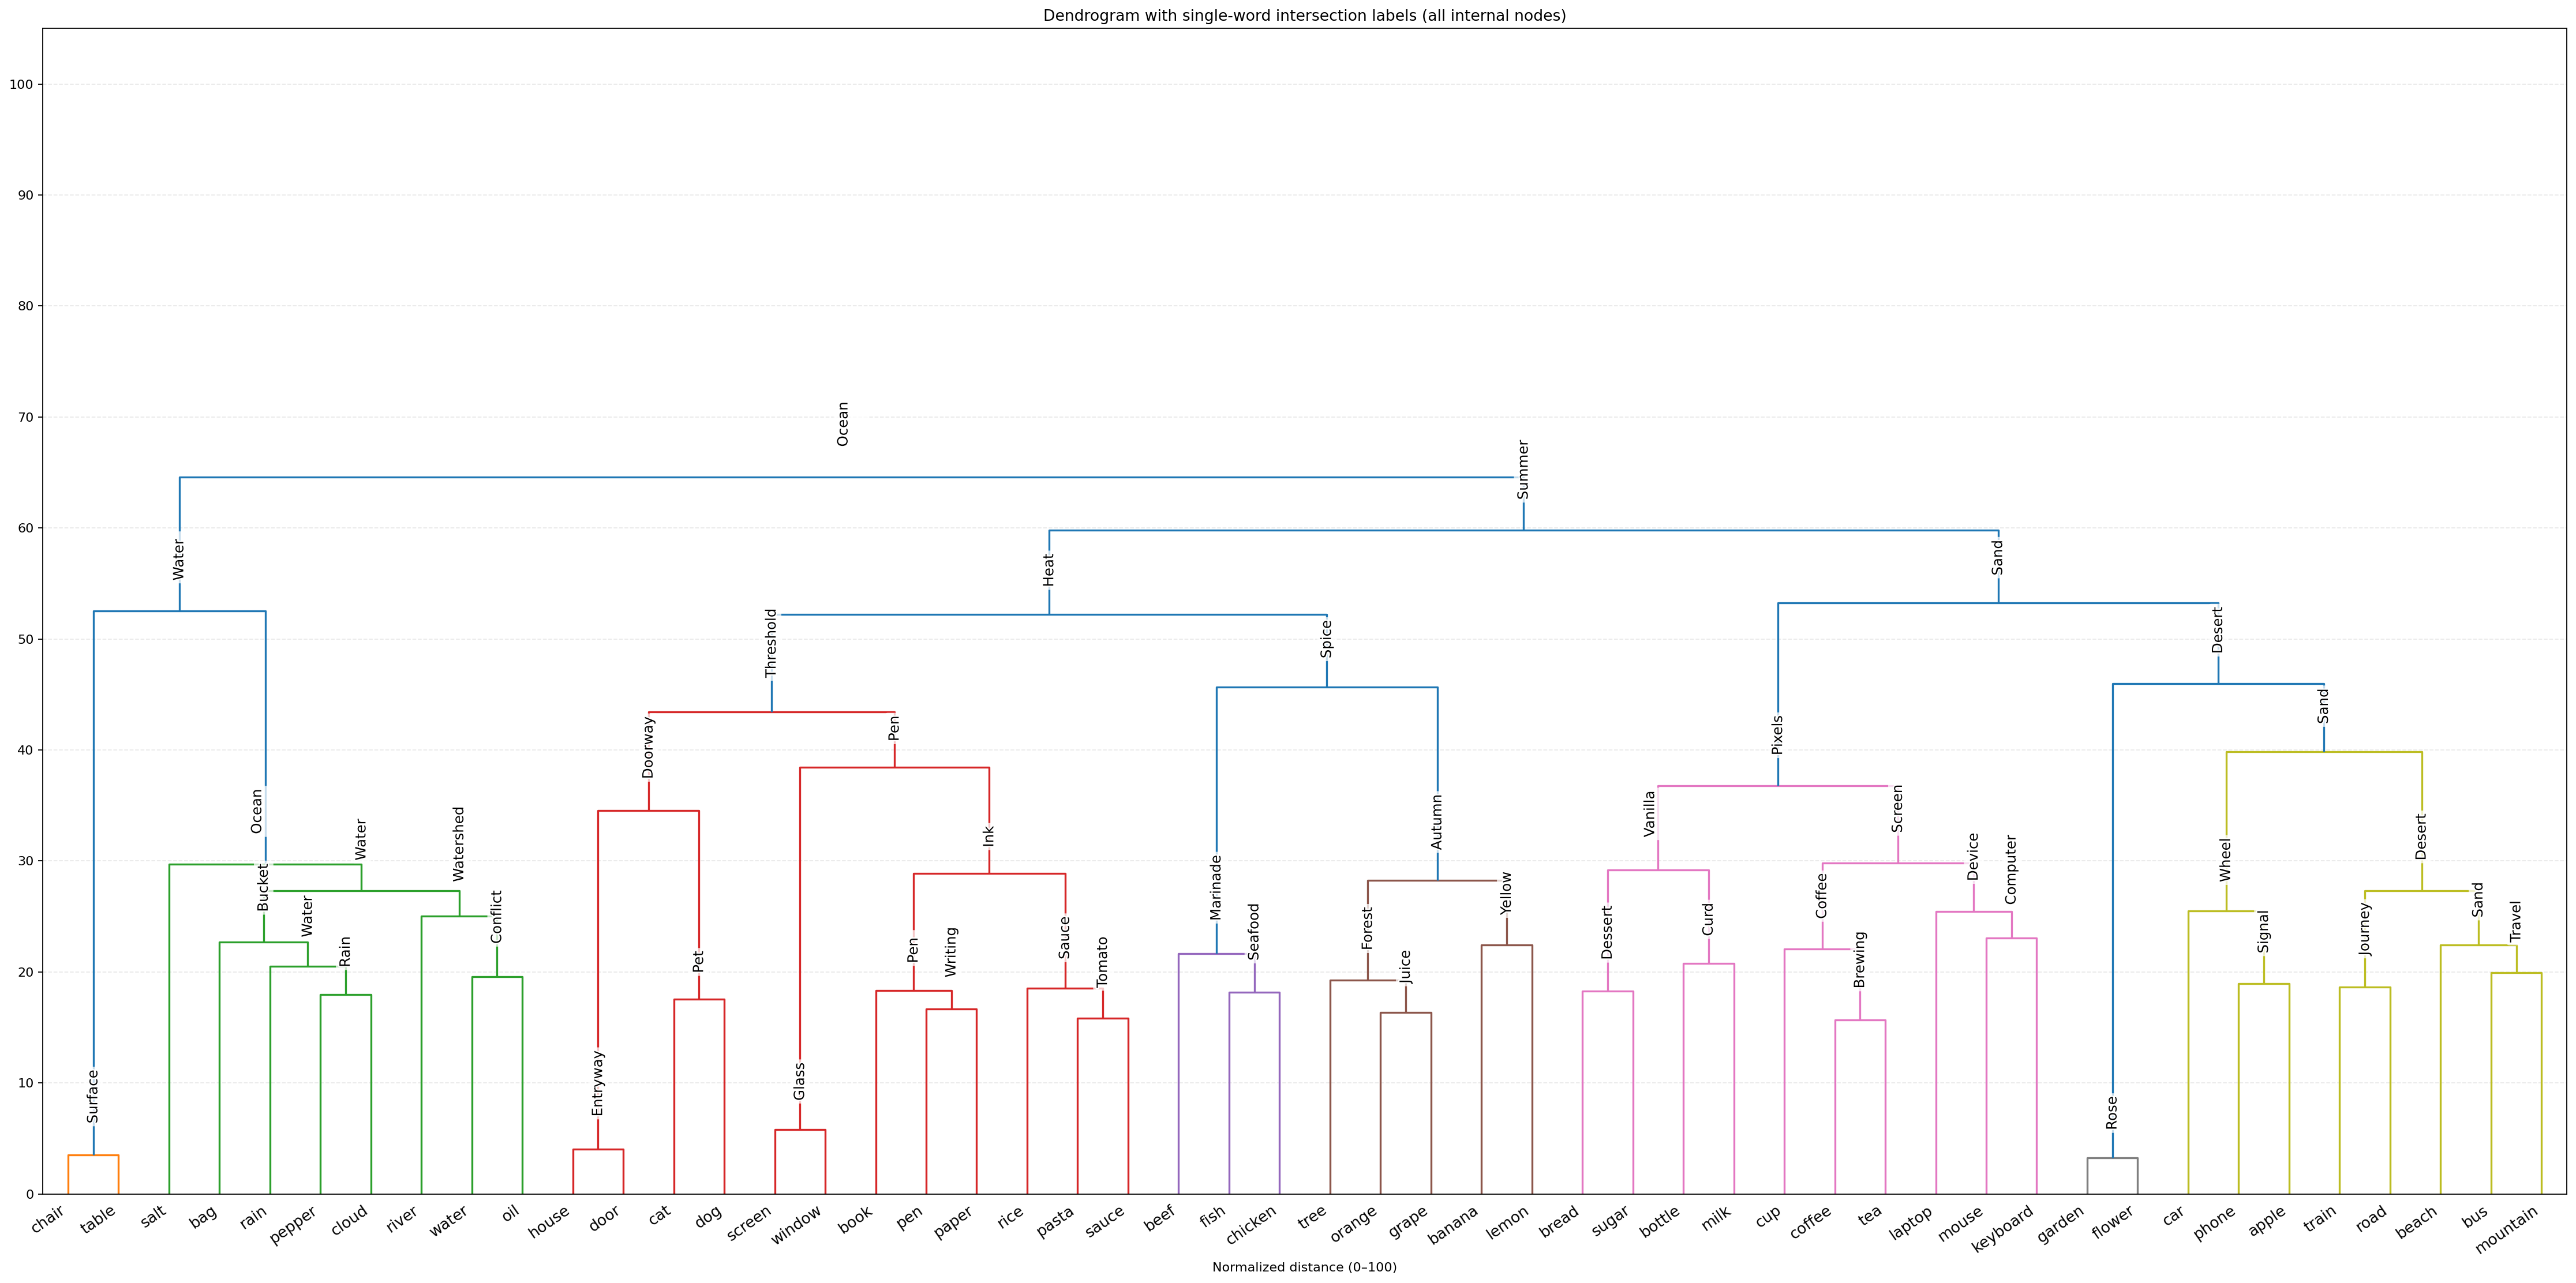

In [148]:
# Generamos el dendograma, se modifico porque no se miraba bien en el output se perdian las palabras
FIGSIZE = (28, 14)
DPI = 160
LEAF_FONT = 12
LEAF_ROT = 35                # inclina hojas
INTERNAL_FONT = 11
BOX_ALPHA = 0.75
Y_OFFSET = 2.0               # offset base para no tocar la línea
EXTRA_OFFSET_PER_CHAR = 0.12 # sube un poco más según largo del texto
MAX_LABEL_LEN = 18           # recorta internos si son larguitos
ANNOTATE_MIN_Y = 0.0         # si quieres ocultar etiquetas muy bajas, súbelo (p.ej. 8.0)

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import matplotlib.patheffects as pe

def _shorten(s, n=MAX_LABEL_LEN):
  s = str(s)
  return s if len(s) <= n else (s[:n-1] + "…")

# === 1) Dibuja el dendrograma base con las etiquetas de HOJAS ===
plt.rcParams['figure.dpi'] = DPI
leaf_labels = df_opt['palabra'].astype(str).tolist()

fig, ax = plt.subplots(figsize=FIGSIZE)

ddata = dendrogram(
    Z,
    labels=leaf_labels,
    orientation='top',
    leaf_font_size=LEAF_FONT,
    distance_sort='ascending',
)

# Inclina hojas (mejor lectura cuando hay muchas)
ax.set_xticklabels(ax.get_xticklabels(), rotation=LEAF_ROT, ha='right')

ax.set_ylim(0, 105)
ax.set_yticks(np.arange(0, 101, 10))
ax.grid(axis='y', linestyle='--', alpha=0.28)
ax.set_title("Dendrogram with single-word intersection labels (all internal nodes)")
ax.set_xlabel("Normalized distance (0–100)")

# === 2) X reales de hojas según el orden del plot ===
n = len(leaf_labels)
leaf_order = ddata['leaves']
xpos_leaf = {leaf_idx: 5 + 10*i for i, leaf_idx in enumerate(leaf_order)}

# === 3) X para cualquier nodo (promedio de hijos)
children = model.children_.astype(int)
_node_x_cache = {}
def node_x(gidx: int) -> float:
    if gidx in _node_x_cache:
        return _node_x_cache[gidx]
    if gidx < n:
        x = xpos_leaf[gidx]
    else:
        a, b = children[gidx - n]
        x = 0.5 * (node_x(int(a)) + node_x(int(b)))
    _node_x_cache[gidx] = x
    return x

# === 4) Etiquetas de nodos internos, bonitas y legibles ===
for i in range(len(children)):
    gidx = n + i
    y = float(dist[i])
    if y < ANNOTATE_MIN_Y:
        continue

    label = _shorten(node_label[gidx])
    if not label:
        continue

    x = node_x(gidx)
    # desfase vertical extra según largo (evita tapar líneas)
    y_txt = y + Y_OFFSET + len(label) * EXTRA_OFFSET_PER_CHAR

    ax.text(
        x, y_txt, label,
        ha='center', va='bottom',
        fontsize=INTERNAL_FONT, rotation=90,
        # cajita blanca semitransparente
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=BOX_ALPHA),
        # contorno blanco para despegar del fondo
        path_effects=[pe.withStroke(linewidth=2.0, foreground="white")]
    )

plt.tight_layout()
plt.show()


## **Conclusion**
Definitivamente vemos una mejora mucho mayor al usar nuestro LLM que creamos ya que a la hora de crearlo le pasamos el system con instrucciones concisas y correctas y eso nos ahorra todo el trabajo de pasar system por prompt y estar haciendo split del output para disminuirlo a 1 sola palabra

El primer intento de usar el llm nos daba conectores gramaticos para las palabras en vez de palabras relacionadas 